In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import mlflow
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [52]:
# server_uri = 'http://127.0.0.1:5000'
# mlflow.set_tracking_uri(server_uri)

In [54]:
import mlflow

current_tracking_uri = mlflow.tracking.get_tracking_uri()
print(f"Current tracking URI: {current_tracking_uri}")


Current tracking URI: http://127.0.0.1:5000


In [48]:
import requests

url = 'http://127.0.0.1:5000/api/2.0/mlflow/experiments/get-by-name?experiment_name=optimization8oil'

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad responses
    print("Connection successful!")
except requests.exceptions.RequestException as e:
    print(f"Connection failed with exception: {e}")
    if isinstance(e, requests.exceptions.ConnectionError):
        print("Connection error details:", e.request.url, e.request.method, e.request.headers)


Connection failed with exception: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=optimization8oil (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002154C3E0C70>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
Connection error details: http://127.0.0.1:5000/api/2.0/mlflow/experiments/get-by-name?experiment_name=optimization8oil GET {'User-Agent': 'python-requests/2.28.1', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}


In [3]:
# prod_in = pd.read_csv('C:\\Users\\jsingh\\Documents\\local_projects\\PC_projects\\QBI\\qcast\\results\\TC_examples_buildup\\Gas_Example_bounds_qi_forecast_2wells.csv', index_col=0)
prod_in = pd.read_csv('./Gas_Example_bounds_qi_forecast.csv', index_col=0)

In [4]:
prod_in = prod_in.reset_index()

In [5]:
prod_in.shape

(20400, 54)

In [6]:
prod_in[~(prod_in['oil_combined_monthly']==prod_in['oil_actual_monthly'])][['oil_combined_monthly', 'oil_actual_monthly']].head()

,oil_combined_monthly,oil_actual_monthly
60,327.337102,NaN
61,356.238701,NaN
62,338.971784,NaN
63,344.495631,NaN
64,327.971562,NaN


In [7]:
prod_in.head()

,api,date,index,days_on,oil_actual_daily,oil_actual_monthly,oil_pred_daily,gas_actual_daily,gas_actual_monthly,gas_pred_daily,...,boe20_pred_cumulative,oil_combined_monthly,gas_combined_monthly,water_combined_monthly,ngl_combined_monthly,boe6_combined_monthly,boe20_combined_monthly,batch_name,unique_id,timestamp
0,3504925141,2018-02-01,1,28,18.571429,520.0,18.571429,0.000000,0.0,NaN,...,520.000000,520.0,0.0,0,0,520.000000,520.00,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1,3504925141,2018-03-01,2,31,343.935484,10662.0,343.935484,443.580645,13751.0,443.580645,...,11869.550000,10662.0,13751.0,0,0,12953.833333,11349.55,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
2,3504925141,2018-04-01,3,30,434.533333,13036.0,359.492601,2124.600000,63738.0,1965.801708,...,25603.030604,13036.0,63738.0,0,0,23659.000000,16222.90,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
3,3504925141,2018-05-01,4,31,227.806452,7062.0,244.537714,1993.903226,61811.0,1869.156942,...,36080.893008,7062.0,61811.0,0,0,17363.833333,10152.55,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
4,3504925141,2018-06-01,5,30,157.333333,4720.0,184.910133,1540.666667,46220.0,1783.519650,...,44303.476480,4720.0,46220.0,0,0,12423.333333,7031.00,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59


In [8]:
well_level_tc_level_index = prod_in.groupby('index')[['oil_combined_monthly', 'oil_pred_monthly']].mean()

In [9]:
well_level_tc_level_index.head()

,oil_combined_monthly,oil_pred_monthly
index,,
1,5371.705882,5371.705882
2,18403.676471,17080.171896
3,15141.500000,15548.009432
4,10981.176471,12555.552054
5,9964.323529,10507.140616


In [10]:
prod_in.api.nunique(), prod_in.index.nunique(), prod_in.date.nunique()

(34, 20400, 633)

In [11]:
well_level_tc_level = prod_in.groupby('date')[['oil_combined_monthly', 'oil_pred_monthly']].mean()

In [12]:
well_level_tc_level.head()

,oil_combined_monthly,oil_pred_monthly
date,,
2017-05-01,2674.142857,2674.142857
2017-06-01,18276.285714,16659.552034
2017-07-01,12999.428571,13476.731009
2017-08-01,6692.133333,6958.209528
2017-09-01,14345.533333,13855.399631


In [13]:
well_level_tc_level['oil_combined_monthly'].iloc[:11].sum()-well_level_tc_level['oil_pred_monthly'].iloc[:11].sum()

-5451.710231440258

In [14]:
well_level_tc_level['oil_combined_monthly'].sum()-well_level_tc_level['oil_pred_monthly'].sum()

-6218.59508128959

In [15]:
well_level_tc_level['oil_combined_monthly'].sum()-well_level_tc_level['oil_pred_monthly'].sum()

-6218.59508128959

In [16]:
prod_pred_avg = prod_in.groupby('index')[['oil_combined_monthly', 'oil_pred_monthly', 'gas_combined_monthly', 'gas_pred_monthly']].mean().reset_index()
prod_pred_avg.head()

,index,oil_combined_monthly,oil_pred_monthly,gas_combined_monthly,gas_pred_monthly
0,1,5371.705882,5371.705882,20703.735294,20744.792734
1,2,18403.676471,17080.171896,83862.970588,80834.157493
2,3,15141.500000,15548.009432,81885.176471,83960.293157
3,4,10981.176471,12555.552054,73334.705882,80218.682342
4,5,9964.323529,10507.140616,71212.205882,74644.103085


In [17]:
prod_pred_avg['oil_combined_monthly'].iloc[:12].sum()-prod_pred_avg['oil_pred_monthly'].iloc[:12].sum()

-3804.439039644698

In [18]:
prod_pred_avg['oil_combined_monthly'].sum()-prod_pred_avg['oil_pred_monthly'].sum()

-3735.102518454194

In [34]:
time__ = prod_pred_avg['index']
qout_ = prod_pred_avg['oil_pred_monthly']
rate__ = prod_pred_avg['oil_combined_monthly']
rate_ = prod_pred_avg['oil_combined_monthly']

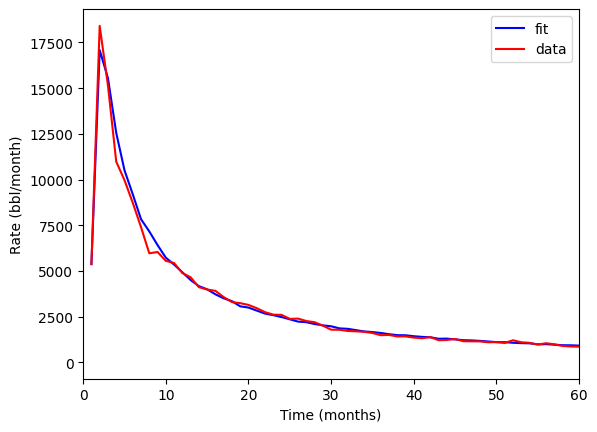

In [20]:
plt.plot((time__), (qout_), 'b-', label='fit')
plt.plot((time__), (rate__), 'r-', label='data')
plt.xlim(0, 60)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

In [21]:
pd.set_option('display.max_columns' , None)

In [22]:
prod_in.head(3)

,api,date,index,days_on,oil_actual_daily,oil_actual_monthly,oil_pred_daily,gas_actual_daily,gas_actual_monthly,gas_pred_daily,water_actual_daily,water_actual_monthly,water_pred_daily,included_oil,included_gas,included_water,peak_index,oil_pred_monthly,gas_pred_monthly,water_pred_monthly,well_name,ngl_actual_daily,ngl_actual_monthly,ngl_actual_cumulative,ngl_pred_daily,ngl_pred_monthly,ngl_pred_cumulative,oil_actual_cumulative,oil_pred_cumulative,gas_actual_cumulative,gas_pred_cumulative,water_actual_cumulative,water_pred_cumulative,boe6_actual_daily,boe6_actual_monthly,boe6_actual_cumulative,boe6_pred_daily,boe6_pred_monthly,boe6_pred_cumulative,boe20_actual_daily,boe20_actual_monthly,boe20_actual_cumulative,boe20_pred_daily,boe20_pred_monthly,boe20_pred_cumulative,oil_combined_monthly,gas_combined_monthly,water_combined_monthly,ngl_combined_monthly,boe6_combined_monthly,boe20_combined_monthly,batch_name,unique_id,timestamp
0,3504925141,2018-02-01,1,28,18.571429,520.0,18.571429,0.000000,0.0,NaN,0.0,0.0,0,False,False,True,-14,520.000000,0.000000,0,N HAYS 2H-5X,0,0,0,0,0,0,520.0,520.000000,0.0,0.000000,0.0,0,18.571429,520.000000,520.000000,18.571429,520.000000,520.000000,18.571429,520.00,520.00,18.571429,520.000000,520.000000,520.0,0.0,0,0,520.000000,520.00,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1,3504925141,2018-03-01,2,31,343.935484,10662.0,343.935484,443.580645,13751.0,443.580645,0.0,0.0,0,False,False,False,-13,10662.000000,13751.000000,0,N HAYS 2H-5X,0,0,0,0,0,0,11182.0,11182.000000,13751.0,13751.000000,0.0,0,417.865591,12953.833333,13473.833333,417.865591,12953.833333,13473.833333,366.114516,11349.55,11869.55,366.114516,11349.550000,11869.550000,10662.0,13751.0,0,0,12953.833333,11349.55,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
2,3504925141,2018-04-01,3,30,434.533333,13036.0,359.492601,2124.600000,63738.0,1965.801708,0.0,0.0,0,True,True,False,-12,10784.778041,58974.051247,0,N HAYS 2H-5X,0,0,0,0,0,0,24218.0,21966.778041,77489.0,72725.051247,0.0,0,788.633333,23659.000000,37132.833333,687.126219,20613.786582,34087.619916,540.763333,16222.90,28092.45,457.782687,13733.480604,25603.030604,13036.0,63738.0,0,0,23659.000000,16222.90,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59


In [23]:
prod_in.describe()

,api,index,days_on,oil_actual_daily,oil_actual_monthly,oil_pred_daily,gas_actual_daily,gas_actual_monthly,gas_pred_daily,water_actual_daily,water_actual_monthly,water_pred_daily,peak_index,oil_pred_monthly,gas_pred_monthly,water_pred_monthly,ngl_actual_daily,ngl_actual_monthly,ngl_actual_cumulative,ngl_pred_daily,ngl_pred_monthly,ngl_pred_cumulative,oil_actual_cumulative,oil_pred_cumulative,gas_actual_cumulative,gas_pred_cumulative,water_actual_cumulative,water_pred_cumulative,boe6_actual_daily,boe6_actual_monthly,boe6_actual_cumulative,boe6_pred_daily,boe6_pred_monthly,boe6_pred_cumulative,boe20_actual_daily,boe20_actual_monthly,boe20_actual_cumulative,boe20_pred_daily,boe20_pred_monthly,boe20_pred_cumulative,oil_combined_monthly,gas_combined_monthly,water_combined_monthly,ngl_combined_monthly,boe6_combined_monthly,boe20_combined_monthly
count,2.040000e+04,20400.000000,20400.000000,2002.000000,2002.000000,20399.000000,2002.000000,2002.000000,20395.000000,2002.0,2002.0,20400.0,20400.000000,20400.000000,20400.000000,20400.0,20400.0,20400.0,20400.0,20400.0,20400.0,20400.0,2002.000000,20400.000000,2.002000e+03,2.040000e+04,2002.0,20400.0,2002.000000,2002.000000,2002.000000,20400.000000,20400.000000,2.040000e+04,2002.000000,2002.000000,2002.000000,20400.000000,20400.000000,2.040000e+04,20400.000000,20400.000000,20400.0,20400.0,20400.000000,20400.000000
mean,3.508055e+09,300.500000,30.437157,106.005075,3226.533966,16.022553,1346.114192,40999.472527,310.008979,0.0,0.0,0.0,288.911765,487.615497,9433.900293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137477.301199,257750.420543,1.417538e+06,4.460417e+06,0.0,0.0,330.357440,10059.779387,373733.709041,67.677267,2059.932212,1.001153e+06,173.310784,5276.507592,208354.223551,31.518417,959.310511,4.807712e+05,481.390326,9604.100921,0.0,0.0,2082.073813,961.595372
std,4.189770e+06,173.209086,0.814937,135.694661,4124.567641,52.733841,789.022063,24088.440049,455.343341,0.0,0.0,0.0,173.722370,1604.674413,13870.485248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68755.264916,137936.286927,8.308378e+05,2.229554e+06,0.0,0.0,242.664224,7391.316332,192998.548577,121.042288,3686.038871,4.457789e+05,164.083304,4991.302341,102259.143070,71.641989,2180.888269,2.096119e+05,1604.115956,14400.823715,0.0,0.0,3734.567470,2185.312670
min,3.504925e+09,1.000000,28.000000,0.000000,0.000000,0.061308,0.000000,0.000000,0.411292,0.0,0.0,0.0,-45.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,200.000000,1.920474,55.693758,2.000000e+02,0.000000,0.000000,60.000000,0.716068,20.765978,6.000000e+01,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,3.504925e+09,150.750000,30.000000,28.459677,874.000000,1.102047,884.935484,26966.000000,55.811327,0.0,0.0,0.0,139.000000,33.511104,1696.760351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89166.000000,160932.851067,7.582412e+05,2.920603e+06,0.0,0.0,182.658602,5555.333333,224740.958333,11.144070,339.406153,7.295170e+05,74.297917,2270.750000,133616.525000,4.378052,133.232163,3.513558e+05,33.405917,1690.816472,0.0,0.0,338.177125,132.881366
50%,3.504925e+09,300.500000,31.000000,54.033986,1658.000000,3.054903,1210.784946,36954.500000,141.851329,0.0,0.0,0.0,289.000000,92.990603,4311.222475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127368.000000,216857.711829,1.363772e+06,4.302328e+06,0.0,0.0,264.389785,8125.250000,370625.416667,27.747961,843.791100,9.647790e+05,117.434677,3573.150000,207973.000000,10.882381,331.290446,4.482533e+05,92.625577,4280.430707,0.0,0.0,840.300737,330.175758
75%,3.513727e+09,450.250000,31.000000,129.165323,3927.000000,9.769403,1627.729839,49570.000000,371.387489,0.0,0.0,0.0,439.000000,297.100168,11294.904568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182951.750000,325291.187275,1.994728e+06,5.634287e+06,0.0,0.0,395.005376,12051.166667,515228.875000,72.089702,2192.194294,1.225283e+06,211.303145,6379.050000,277889.100000,28.663877,871.091147,5.960481e+05,296.032073,11207.797011,0.0,0.0,2179.681967,867.141468
max,3.513728e+09,600.000000,31.000000,1282.827586,37202.000000,

In [24]:
prod_avg = prod_in.groupby('index')[['oil_combined_monthly', 'gas_combined_monthly']].mean().reset_index()
prod_avg.head()

,index,oil_combined_monthly,gas_combined_monthly
0,1,5371.705882,20703.735294
1,2,18403.676471,83862.970588
2,3,15141.500000,81885.176471
3,4,10981.176471,73334.705882
4,5,9964.323529,71212.205882


In [25]:
def exponential1(t,q0,alpha):
    # print("params in expo", t, q0, alpha)
    q = q0*np.exp(-alpha*t)
    print(q)
    N = q.cumsum()
    return q

In [26]:
print(exponential1(5, 12, 0.1))

7.278367916551601
7.278367916551601


In [24]:
def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: array of floats. Time since the well first came online, can be in various units
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output:
        Returns q, or the expected production rate at time t. Float.
    """
    eps =10e-8
    if b<eps:
        b=eps
    if qi<eps:
        qi=eps
    if di<eps:
        di = eps
    if di>1-eps:
        di = 1-eps
    if b>2:
        b=2
    # print("qi", qi)
    # print("params for hyperbo", t[:5], b, di)
    q = qi/((1.0+b*di*t)**(1.0/b))
    # print(q[:5])
    # print(len(q))
    N = q.cumsum()
    return q

In [25]:

def exponential(t,q0,alpha):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units
        (days, months, etc) so long as they are consistent.
        q0: Float. Initial production rate when well first came online.
        alpha: Float. Exponential decline constant
    Output:
        Returns q, or the expected production rate at time t. Float.
    """
    eps =10e-8
    if alpha<eps:
        alpha=eps
    if q0<eps:
        q0=eps
    # print("params in expo", t, q0, alpha)
    q = q0*np.exp(-alpha*t)
    # print(q)
    N = q.cumsum()
    return q

def linear(t,q0,m):
    """
    Linear decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units
        (days, months, etc) so long as they are consistent.
        q0: Float. Initial production rate when well first came online.
        m: Float. Linear decline constant
    Output:
        Returns q, or the expected production rate at time t. Float.
    """
    eps =10e-8
    if m<eps:
        m=eps
    if q0<eps:
        q0=eps
    q = q0+m*t
    N = q.cumsum()
    return q

def multi_segment(t, t0_idx,q0,m,texp_idx,alpha,b,di):
    # print('t0_idx',t0_idx)
    # print('texp_idx',texp_idx)
    # print('thyp_idx',len(t))
    thyp_idx = len(t) # forecast length is 600 months (fixed)
    t0_idx = int(t0_idx)
    texp_idx = int(texp_idx)
    thyp_idx = int(thyp_idx)
    t0 = np.arange(0,t0_idx)
    qexp =   q0+m*t0_idx
    if texp_idx-t0_idx<0:
        texp = 0
        qi = qexp
        texp_idx = t0_idx
        thyp = np.arange(0,thyp_idx-texp_idx)
    else:
        texp = np.arange(0,texp_idx-t0_idx)
        thyp = np.arange(0,thyp_idx-texp_idx)
        qi = qexp*np.exp(-alpha*(texp_idx-t0_idx))

    q_linear = linear(t0,q0,m)
    q_exp = exponential(texp,qexp,alpha)
    q_hyp = hyperbolic_equation(thyp,qi,b,di)
    # print('q_linear', q_linear)
    # print('q_exp', q_exp)
    # print('q_hyp', q_hyp)

    if texp_idx-t0_idx<0:
        q_total = np.concatenate((q_linear,q_hyp))
    else:
        q_total = np.concatenate((q_linear,q_exp,q_hyp))
    return q_total

def multi_segment2(t,t0_idx,q0,qpeak,texp_idx,alpha,b,di):
    thyp_idx = len(t)-1 # forecast length is 600 months (fixed)
    t0_idx = int(t0_idx)
    texp_idx = int(texp_idx)
    thyp_idx = int(thyp_idx)
    t0 = np.arange(0,t0_idx)
    if t0_idx>0:
        m=(qpeak-q0)/t0_idx
    else:
        m=0

    if texp_idx-t0_idx<0:
        texp = 0
        qi = qpeak
        # texp_idx = t0_idx
        thyp = np.arange(0,thyp_idx-t0_idx+1)
    else:
        texp = np.arange(0,texp_idx-t0_idx)
        thyp = np.arange(0,thyp_idx-texp_idx+1)
        qi = qpeak*np.exp(-alpha*(texp_idx-t0_idx))
    q_linear = linear(t0,q0,m)
    q_exp = exponential(texp,qpeak,alpha)
    q_hyp = hyperbolic_equation(thyp,qi,b,di)
    if texp_idx-t0_idx<0:
        q_total = np.concatenate((q_linear,q_hyp))
    else:
        q_total = np.concatenate((q_linear,q_exp,q_hyp))
    return q_total




In [29]:
np.arange(0,0)

array([], dtype=int32)

In [30]:
#change done by in multi_segment2: if texp_idx-t0_idx<0:
        # texp = 0
        # qi = qpeak
        # # texp_idx = t0_idx
        # thyp = np.arange(0,thyp_idx-texp_idx)

In [26]:
def error_eval(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    # print('params',params)
    alpha,b,di = params
    # print("alpha0", alpha, "b",b, "di",di)
    #q0 = 17131.5
    # t0_idx=1
    #q_pred = multi_segment(time, t0_idx,q0,m,texp_idx,alpha,b,di)
    q_pred = multi_segment2(time,t0_idx,q0, qpeak, texp_idx,alpha,b,di)
    error = np.sum((q_in-q_pred)**2)
    eur12_diff = (q_in[0:12].sum()-q_pred[0:12].sum())**2
    eur_diff = (q_in.sum()-q_pred.sum())**2
    # print('error',error,'eur12_diff',eur12_diff,'eur_diff',eur_diff)
    weight = 0.15
    # weight = 0
    weighted_error = eur12_diff*(1-weight)+error*0+eur_diff*weight

    return weighted_error

def error_eval_mse(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    alpha,b,di = params
    q_pred = multi_segment2(time,t0_idx,q0, qpeak, texp_idx,alpha,b,di)
    mse = mean_squared_error(q_in, q_pred)
    return mse

def error_eval_mae(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    alpha,b,di = params
    q_pred = multi_segment2(time,t0_idx,q0, qpeak, texp_idx,alpha,b,di)
    mae = mean_absolute_error(q_in, q_pred)
    return mae

def error_eval_hubber_loss(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    # alpha,b,di, delta = params
    delta = 1
    alpha,b,di = params
    print(params)
    q_pred = multi_segment2(time,t0_idx,q0, qpeak, texp_idx,alpha,b,di)
    # print(q_in, q_pred)
    huber_mse = 0.5*(q_in-q_pred)**2
    huber_mae = delta * (np.abs(q_in - q_pred) - 0.5 * delta)
    # print("huber_mae", huber_mae, "huber_mse", huber_mse)
    # print("q_in", q_in)
    # print("q_pred", q_pred)
    hubber_loss =  np.where(np.abs(q_in - q_pred) <= delta, huber_mse, huber_mae)
    # print(f"hubber loss : {hubber_loss}")
    print("hubber_loss", np.sum(hubber_loss))
    # print(value)
    return np.sum(hubber_loss)

In [32]:
r_list = []
iguess = [0.1, 1.02, 0.75] #alpha , b, di
time_ = prod_avg['index']
rate_ = prod_avg['oil_combined_monthly']
bounds_hubber_loss = [ (0, 1), (0.1, 1.2), (0, None), (1, 10)]
iguess_hubber_loss = [0.1, 1.02, 0.75, 1]
bounds = [ (0, 1), (0.1, 1.2), (0, None)] #(0, 10),,0.018400049425550256, 1.0461257833274875, 0.42920038566470087
t0_idx = np.argmax(rate_)
qmax = rate_.max()
q0 = rate_[0]

texp_idx_arr = np.arange(0, 20, 1)
# a = ["trust-krylov" ,"trust-ncg", "trust-exact", "trust-krylov", "dogleg"]
for i in range (len(texp_idx_arr)):
    # r_list.append(minimize(error_eval_hubber_loss, iguess_hubber_loss, args=(t0_idx,q0,qmax,i , time_, rate_), bounds=bounds_hubber_loss, method="L-BFGS-B"))
    r_list.append(minimize(error_eval, iguess, args=(t0_idx,q0,qmax,i , time_, rate_), bounds=bounds, method="L-BFGS-B"))
# result_list.append(minimize(error_eval_hubber_loss, iguess_hubber_loss, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds_hubber_loss, method=method))

NameError: name 'prod_avg' is not defined

In [34]:
q_pred1 = multi_segment2(time_,t0_idx,q0, qmax, 3,0.12, 1.1, 0.70)

linear_time [0]
exp length 2
lenght of hyp 597
q_linear [5371.70588235]
q_exp [18403.67647059 16322.5967725 ]


In [35]:
q_pred1[:15]

array([ 5371.70588235, 18403.67647059, 16322.5967725 , 14476.84465782,
        8614.76970502,  6203.59250786,  4876.44141303,  4032.0723049 ,
        3445.65930537,  3013.66827   ,  2681.639579  ,  2418.13341076,
        2203.70184313,  2025.6551048 ,  1875.35298588])

In [36]:
import plotly.express as px
fig = px.scatter(prod_avg.head(20), x='index', y='oil_combined_monthly')
fig.show()

In [34]:
from scipy.optimize import minimize, rosen, rosen_der, approx_fprime
def jacobian_error(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    eps = np.sqrt(np.finfo(float).eps)
    return approx_fprime(params, error_eval_hubber_loss, eps, t0_idx, q0, qpeak, texp_idx, time, q_in)

In [95]:
bounds

[(0, 1), (0.1, 1.2), (0, None)]

In [98]:
rate_[:20]

0      5371.705882
1     18403.676471
2     15141.500000
3     10981.176471
4      9964.323529
5      8727.911765
6      7394.441176
7      5963.382353
8      6034.529412
9      5550.323529
10     5430.764706
11     4884.323529
12     4651.323529
13     4109.617647
14     3983.147059
15     3908.264706
16     3566.852941
17     3292.470588
18     3234.470588
19     3138.617647
Name: oil_combined_monthly, dtype: float64

linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
linear_tim

In [118]:
fun_Val = []
for r in r_list:
    fun_Val.append(r.fun)

In [119]:
r_list[0]

      fun: 8.989124614863386e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -8.70612036e-06, -3.92757116e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 14
     njev: 24
   status: 0
  success: True
        x: array([0.1       , 0.86966217, 0.27018291])

In [120]:
fun_Val

[8.989124614863386e-05,
 8.989124614863386e-05,
 6.185884145514928e-06,
 4.607470056618411e-06,
 1.4612713809817523e-05,
 9.126256173629361e-07,
 1.6303429256583547e-06,
 1.0579681681688241e-05,
 2.216369818429489e-05,
 1.898767289966855e-05,
 3.2303615116619525e-05,
 3.4910918163085706e-06,
 2.8561779226918756e-06,
 2.979425038260467e-05,
 2.978875512927235e-05,
 4.3071776477749185e-05,
 0.00012003456188936455,
 7.106456942121315e-05,
 0.0009900093003377749,
 0.002455808689783287]

In [121]:
fun_Val[np.argmin(fun_Val)]

9.126256173629361e-07

In [122]:
opt_idx  = np.argmin(fun_Val)
opt_idx

5

In [123]:
opt_idx  = np.argmin(fun_Val)
alpha,b,di = r_list[opt_idx].x
alpha,b,di

(0.16260010483439774, 1.1966863423361285, 0.3205407336119339)

In [124]:
opt_idx

5

In [125]:
qout = multi_segment2(time_, t0_idx, q0,qmax,opt_idx, alpha,b,di)

linear_time [0]
exp length 4
lenght of hyp 595
q_linear [5371.70588235]
q_exp [18403.67647059 15641.8552156  13294.49770413 11299.40577821]


In [126]:
eur12_diff = (qout[0:11].sum()-rate_[0:11].sum())*100/rate_[0:11].sum()
eur_diff = (qout.sum()-rate_.sum())*100/rate_.sum()
print('eur12_diff',eur12_diff)
print('eur_diff',eur_diff)

eur12_diff 1.358586264979258
eur_diff 8.399994553517002e-07


In [70]:
def error_evalx(q_pred, q_in):
    error = np.sum((q_in-q_pred)**2)
    eur12_diff = (q_in[0:11].sum()-q_pred[0:11].sum())**2
    eur_diff = (q_in.sum()-q_pred.sum())**2
    print("eur12_diff", eur12_diff)
    print("eur_diff", eur_diff)
    print()
    weight = 0.15
    weighted_error = eur12_diff*(1-weight)+error*0+eur_diff*weight

    return weighted_error

In [73]:
qout[0:20]

array([ 5371.70588235, 18403.67647059, 14407.09407034, 11278.41819451,
        9766.5800415 ,  8586.89734591,  7643.07351974,  6872.37278505,
        6232.25735587,  5692.91463828,  5232.86053252,  4836.24035289,
        4491.11103242,  4188.31338973,  3920.71151133,  3682.66743315,
        3469.67063526,  3278.07178872,  3104.88817913,  2947.65933905])

In [74]:
print(error_evalx(qout, rate_))

eur12_diff 274697.10192222777
eur_diff 40661820.64718812

6332765.633712112


In [46]:
error_evalx(qout, rate_) # mae

6332765.633712112

In [47]:
error_evalx(qout, rate_) # weighted error

6332765.633712112

In [48]:
error_evalx(qout, rate_) # MSE

6332765.633712112

In [49]:
qout[0:11].sum()-rate_[0:11].sum(), qout.sum()-rate_.sum()


(524.1155425306788, 6376.662187005684)

In [50]:
qout[:20]

array([ 5371.70588235, 18403.67647059, 14407.09407034, 11278.41819451,
        9766.5800415 ,  8586.89734591,  7643.07351974,  6872.37278505,
        6232.25735587,  5692.91463828,  5232.86053252,  4836.24035289,
        4491.11103242,  4188.31338973,  3920.71151133,  3682.66743315,
        3469.67063526,  3278.07178872,  3104.88817913,  2947.65933905])

In [51]:
rate_[:20]

0      5371.705882
1     18403.676471
2     15141.500000
3     10981.176471
4      9964.323529
5      8727.911765
6      7394.441176
7      5963.382353
8      6034.529412
9      5550.323529
10     5430.764706
11     4884.323529
12     4651.323529
13     4109.617647
14     3983.147059
15     3908.264706
16     3566.852941
17     3292.470588
18     3234.470588
19     3138.617647
Name: oil_combined_monthly, dtype: float64

In [37]:
eur12_diff = (qout[0:11].sum()-rate_[0:11].sum())*100/rate_[0:11].sum()
eur_diff = (qout.sum()-rate_.sum())*100/rate_.sum()
print('eur12_diff',eur12_diff)
print('eur_diff',eur_diff)

NameError: name 'qout' is not defined

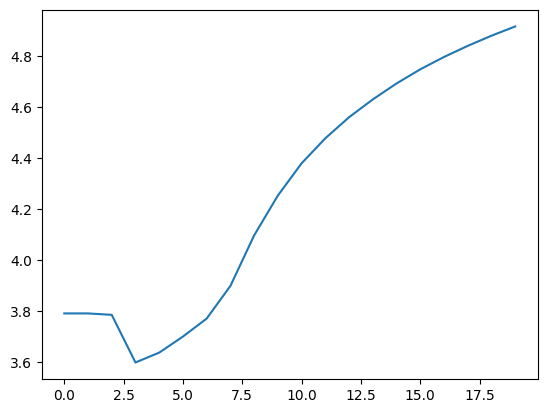

In [53]:
plt.plot(np.log10(fun_Val)) # mse

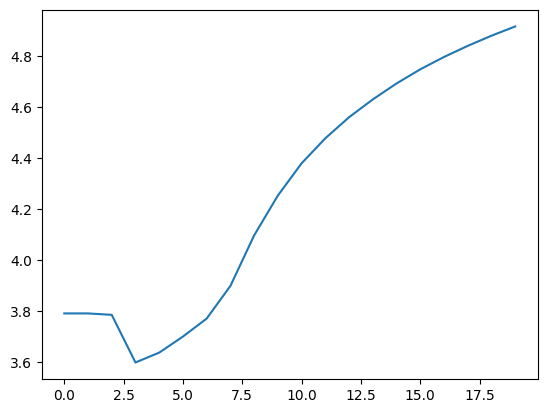

In [54]:
plt.plot(np.log10(fun_Val)) # mae

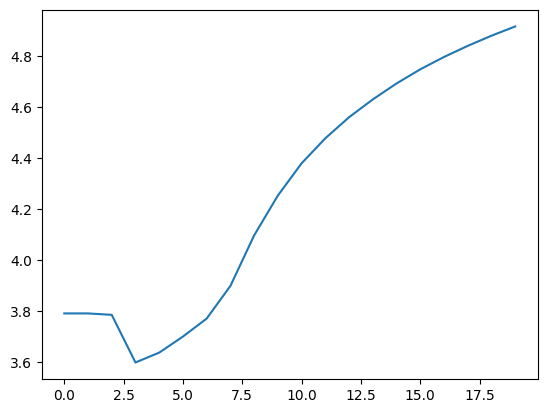

In [55]:
plt.plot(np.log10(fun_Val)) # eval function

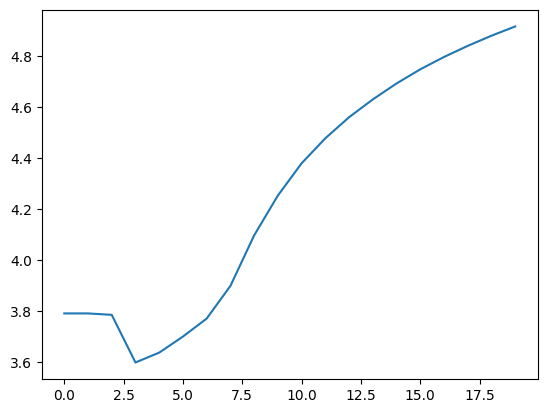

In [56]:
plt.plot(np.log10(fun_Val)) # MAE

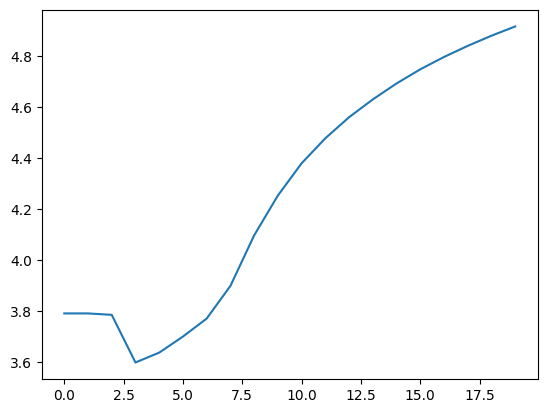

In [57]:
plt.plot(np.log10(fun_Val)) # MAE

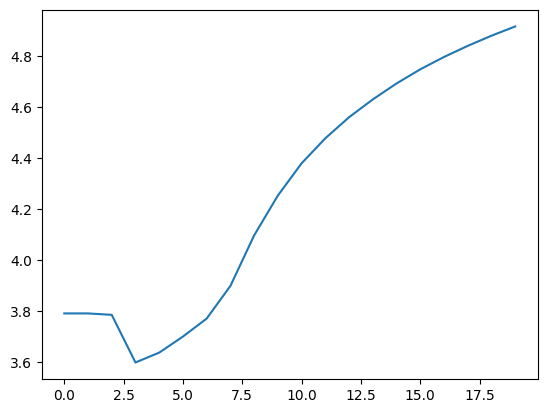

In [58]:
plt.plot(np.log10(fun_Val)) # MSE

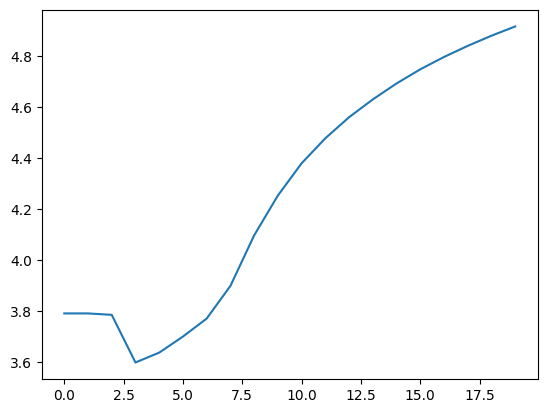

In [59]:
plt.plot(np.log10(fun_Val)) # custom error function

In [60]:
q_in = 100
q_pred = 120
delta = 1
huber_mse = 0.5*(q_in-q_pred)**2
huber_mae = delta * (np.abs(q_in - q_pred) - 0.5 * delta)
print(huber_mae, huber_mse)
print(np.where(np.abs(q_in - q_pred) <= delta, huber_mse, huber_mae))

19.5 200.0
19.5


In [61]:
# # creating experiment name in mlflow
# experiment_DT = "Demo"
# mlflow.create_experiment(experiment_DT)

In [62]:
np.arange(0,11)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [63]:
iguess = [0.1, 1.02, 0.75] #alpha , b, di
time_ = prod_avg['index']
rate_ = prod_avg['oil_combined_monthly']

In [64]:
q_pred = multi_segment2(time_,t0_idx,q0, qmax, 4,0.1,1.02,1)
q_pred

linear_time [0]
exp length 3
lenght of hyp 596
q_linear [5371.70588235]
q_exp [18403.67647059 16652.33510002 15067.65589617]


array([ 5371.70588235, 18403.67647059, 16652.33510002, 15067.65589617,
       13633.77885694,  6843.08885471,  4583.64315661,  3451.61324526,
        2770.72250483,  2315.71479403,  1989.99315386,  1745.20825393,
        1554.4669943 ,  1401.61348143,  1276.35405911,  1171.81809558,
        1083.24352873,  1007.22513299,   941.26310513,   883.4806974 ,
         832.44136081,   787.02674363,   746.35315164,   709.71302612,
         676.53311164,   646.34401088,   618.75766607,   593.45045865,
         570.15035665,   548.6270217 ,   528.68410983,   510.15321835,
         492.88908239,   476.76572989,   461.67337905,   447.51591625,
         434.20883129,   421.67751627,   409.8558553 ,   398.68504872,
         388.1126275 ,   378.09162287,   368.57986343,   359.53937733,
         350.9358818 ,   342.7383454 ,   334.91861115,   327.45107097,
         320.31238337,   313.48122794,   306.93809097,   300.66507797,
         294.64574889,   288.86497326,   283.30880215,   277.96435499,
      

In [65]:
t0_idx = np.argmax(rate_)
texp_idx = 12
q0 = rate_[0]
qmax = rate_[t0_idx]
alpha =0.1
b = 1.02
di = 0.75
q_pred = multi_segment2(time_,t0_idx,q0, qmax, texp_idx,alpha,b,di)

linear_time [0]
exp length 11
lenght of hyp 588
q_linear [5371.70588235]
q_exp [18403.67647059 16652.33510002 15067.65589617 13633.77885694
 12336.35325899 11162.39403084 10100.15179397  9138.99527103
  8269.30488448  7482.37648062  6770.3342155 ]


In [66]:
print(t0_idx), prod_avg.iloc[1]

1


(None,
 index                       2.000000
 oil_combined_monthly    18403.676471
 gas_combined_monthly    83862.970588
 Name: 1, dtype: float64)

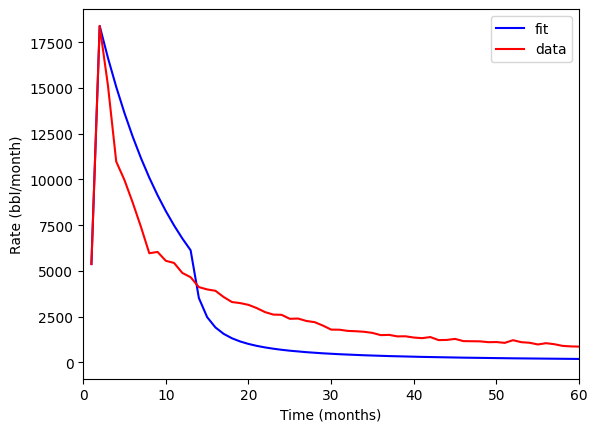

In [67]:
plt.plot((time_), (q_pred), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 60)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

In [27]:
# methods = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "SLSQP"]
methods = ['L-BFGS-B']
# methods = ["trust-krylov"] #,"trust-ncg", "trust-exact", "trust-krylov"
regression_matrix = ["Hubber_loss", "MSE", "MAE", "weighted_mix_error"]
#Jacobian is required for Newton-CG method
#Jacobian is required for dogleg minimization
# Jacobian is required for Newton-CG trust-region minimization

In [20]:
# # creating experiment name in mlflow
experiment_DT = "optimization111"
mlflow.create_experiment(experiment_DT)

'453501033281706715'

In [21]:
result_list = []

for method in methods:

    for i in range (len(texp_idx_arr)):


        result_list.append(minimize(error_eval, iguess, args=(i,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
fun_val = []
for i,j in enumerate(result_list):
    fun_val.append(result_list[i].fun)
opt_idx = np.argmin(fun_val)
alpha,b,di, delta = result_list[opt_idx].x


NameError: name 'methods' is not defined

In [22]:
if mlflow.active_run():
    mlflow.end_run()

In [38]:
time_ = time__

In [41]:
bounds = [ (0, 1), (0.1, 1.2), (0, None)] #(0, 10),,0.018400049425550256, 1.0461257833274875, 0.42920038566470087
bounds_hubber_loss = [ (0, 1), (0.1, 1.2), (0, None)]
iguess_hubber_loss = [0.1, 1.02, 0.75]
t0_idx = np.argmax(rate_)
qmax = rate_.max()
q0 = rate_[0]

texp_idx_arr = np.arange(0, 15, 1)

mlflow_runs  =0
for reg_matrix in regression_matrix:
    for method in methods:
        result_list = []
        for i,j in enumerate(texp_idx_arr):
            texp_idx = j
            if reg_matrix=="MSE":
                result_list.append(minimize(error_eval_mse, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
            elif reg_matrix=="MAE":
                result_list.append(minimize(error_eval_mae, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
            elif reg_matrix=="Hubber_loss":
                result_list.append(minimize(error_eval_hubber_loss, iguess_hubber_loss, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds_hubber_loss, method=method))
            elif reg_matrix=="weighted_mix_error":
                result_list.append(minimize(error_eval, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
        fun_val = []
        for i,j in enumerate(result_list):
            fun_val.append(result_list[i].fun)

        opt_idx = np.argmin(fun_val)
        minimim_fun_val = min(fun_val)
        if reg_matrix=="Hubber_loss":
            alpha,b,di = result_list[opt_idx].x
        else:
            alpha,b,di = result_list[opt_idx].x
        qout = multi_segment2(time__, t0_idx, q0,qmax,opt_idx+1, alpha,b,di)
        eur12_diff = (qout[0:11].sum()-rate_[0:11].sum())*100/rate_[0:11].sum()
        fig_lim60 = px.line(time__[:60], y=[rate_[:60], qout[:60]], labels={'y': 'Values'}, color_discrete_sequence=['blue', 'red'])
        fig_lim60.update_layout(title='Graph with xlimit=60')
        fig_lim60.write_html("graph_xlimit_60.html")
        mlflow.log_artifact("graph_xlimit_60.html", "graphs")

        fig_lim600 = px.line(time__, y=[rate_, qout], labels={'y': 'Values'}, color_discrete_sequence=['blue', 'red'])
        fig_lim600.update_layout(title='Graph with xlimit=600')
        fig_lim600.write_html("graph_xlimit_600.html")
        mlflow.log_artifact("graph_xlimit_600.html", "graphs")

        eur_diff = (qout.sum()-rate_.sum())*100/rate_.sum()
        with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name(experiment_DT).experiment_id):
            mlflow.log_param("alpha", alpha)
            mlflow.log_param("b", b)
            mlflow.log_param("di", di)
            mlflow.log_param("index_exp",opt_idx)
            mlflow.log_param("evaluation_matrix_for_optimization",reg_matrix)
            mlflow.log_param("method_minimize_function",method)
            # if reg_matrix=="Hubber_loss":
            #     mlflow.log_param("delta_in_hubber_loss",delta)

            # mlflow.log_metric(f"minimum_value_of_eval_matrix: {reg_matrix}", minimim_fun_val)
            mlflow.log_metric("eur12_diff",eur12_diff)
            mlflow.log_metric("eur_diff",eur_diff)
            mlflow.log_metric("combined_eur12_eur_diff", abs(eur12_diff)+abs(eur_diff))
            mlflow_runs+=1
            # print(f'{mlflow_runs} successful')



[0.1  1.02 0.75]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 122780.68657828527
[0.10000001 1.02       0.75      ]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 122780.68657828527
[0.1        1.02000001 0.75      ]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 122780.68421343909
[0.1        1.02       0.75000001]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 122780.68799771843
[0.1 1.2 0. ]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 10739711.119100746
[0.10000001 1.2        0.        ]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 10739711.119100746
[0.1        1.19999999 0.        ]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 10739711.119100748
[1.0e-01 1.2e+00 1.0e-08]
linear_time [0]
q_linear [5371.70588235]
q_exp 18403.676470588234
hubber_loss 10739711.11

Exception: Run with UUID 2970d68e56064a3f9dce67993cb077b0 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [40]:
import plotly.express as px

In [ ]:
bounds = [ (0, 1), (0.1, 1.2), (0, None)] #(0, 10),,0.018400049425550256, 1.0461257833274875, 0.42920038566470087
t0_idx = np.argmax(rate_)
qmax = rate_.max()
q0 = rate_[0]

texp_idx_arr = np.arange(0, 15, 1)
method = "Nelder-Mead"
mlflow_runs  =0
for reg_matrix in regression_matrix:
    # for method in methods:
    result_list = []
    for i,j in enumerate(texp_idx_arr):
        texp_idx = j
        if reg_matrix=="MSE":
            result_list.append(minimize(error_eval_mse, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
        elif reg_matrix=="MAE":
            result_list.append(minimize(error_eval_mae, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
        elif reg_matrix=="Hubber_loss":
            result_list.append(minimize(error_eval_hubber_loss, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
        elif reg_matrix=="weighted_mix_error":
            result_list.append(minimize(error_eval, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method=method))
    fun_val = []
    for i,j in enumerate(result_list):
        fun_val.append(result_list[i].fun)

    opt_idx = np.argmin(fun_val)
    minimim_fun_val = min(fun_val)
    alpha,b,di = result_list[opt_idx].x
    qout = multi_segment2(time_, t0_idx, q0,qmax,opt_idx+1, alpha,b,di)
    eur12_diff = (qout[0:11].sum()-rate_[0:11].sum())*100/rate_[0:11].sum()
    eur_diff = (qout.sum()-rate_.sum())*100/rate_.sum()
    with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name(experiment_DT).experiment_id):
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("b", b)
        mlflow.log_param("di", di)
        mlflow.log_param("index_exp",opt_idx)
        mlflow.log_param("evaluation_matrix_for_optimization",reg_matrix)
        mlflow.log_param("method_minimize_function",method)

        # mlflow.log_metric(f"minimum_value_of_eval_matrix: {reg_matrix}", minimim_fun_val)
        mlflow.log_metric("eur12_diff",eur12_diff)
        mlflow.log_metric("eur_diff",eur_diff)
        mlflow_runs+=1
        print(f'{mlflow_runs} successful')



1 successful
2 successful
3 successful
4 successful


In [ ]:
type(result_list), len(result_list), type(result_list[0]), len(result_list[0])

(list, 40, scipy.optimize._optimize.OptimizeResult, 10)

In [ ]:
result_list[0]

      fun: 34.1994714570036
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.46962611, -7.0073412 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 248
      nit: 16
     njev: 62
   status: 0
  success: True
        x: array([0.1       , 0.83483741, 0.23836025])

In [ ]:
fun_val = []
for i,j in enumerate(result_list):
    fun_val.append(result_list[i].fun)

opt_idx = np.argmin(fun_val)


In [ ]:
a = result_list[opt_idx].fun
a

27.72183518250057

In [ ]:
alpha,b,di = result_list[opt_idx].x # t0_idx,q0,m,texp_idx,alpha,b,di
alpha,b,di

(0.20451312778222222, 0.7691022096812685, 0.10436349764322071)

In [ ]:
alpha,b,di = result_list[opt_idx].x # t0_idx,q0,m,texp_idx,alpha,b,di
alpha,b,di

(0.018400049425550256, 1.0461257833274875, 0.42920038566470087)

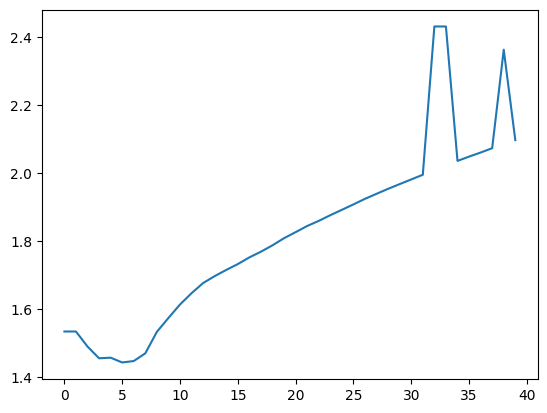

In [ ]:
plt.plot(np.log10(fun_val))

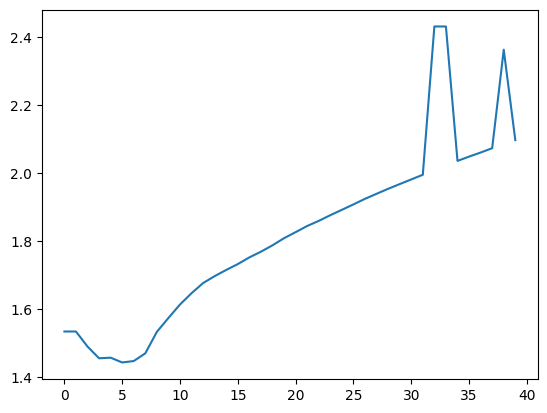

In [ ]:
plt.plot(np.log10(fun_val))

(0.018400049425550256, 1.0461257833274875, 0.42920038566470087)

In [ ]:
#qout= multi_segment2(time_, t0_idx, q0,m,opt_idx+1, alpha,b,di)
qout = multi_segment2(time_, t0_idx, q0,qmax,opt_idx+1, alpha,b,di)

(1,) (5,) (594,)


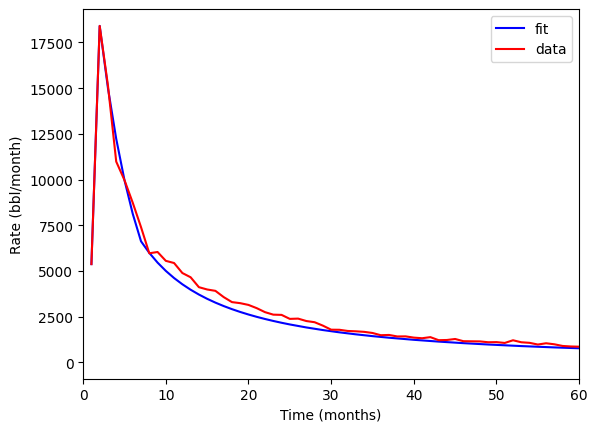

In [ ]:
plt.plot((time_), (qout), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 60)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

In [ ]:
eur12_diff = (qout[0:11].sum()-rate_[0:11].sum())*100/rate_[0:11].sum()
eur_diff = (qout.sum()-rate_.sum())*100/rate_.sum()
print('eur12_diff',eur12_diff)
print('eur_diff',eur_diff)

eur12_diff -2.2309970073634084
eur_diff -9.442594427289908


In [ ]:
# try to make eur12, eur minimum (todo)

In [ ]:
opt_idx

5

In [ ]:
with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name(experiment_DT).experiment_id):
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("b", b)
    mlflow.log_param("di", di)
    mlflow.log_param("index_exp",opt_idx)
    mlflow.log_metric("Value of objective function",a)
    mlflow.log_metric("eur12_diff",eur12_diff)
    mlflow.log_metric("eur_diff",eur_diff)

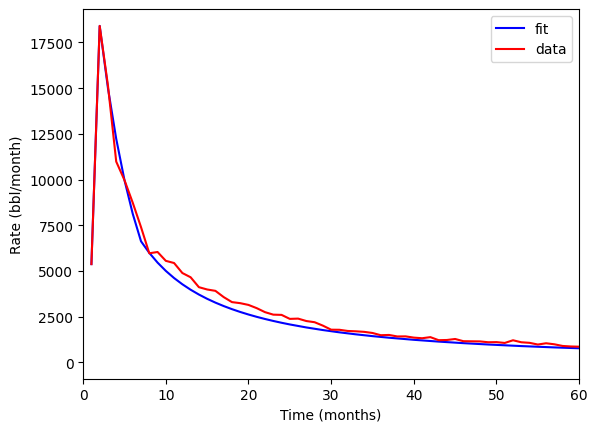

In [ ]:


plt.plot((time_), (qout), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 60)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

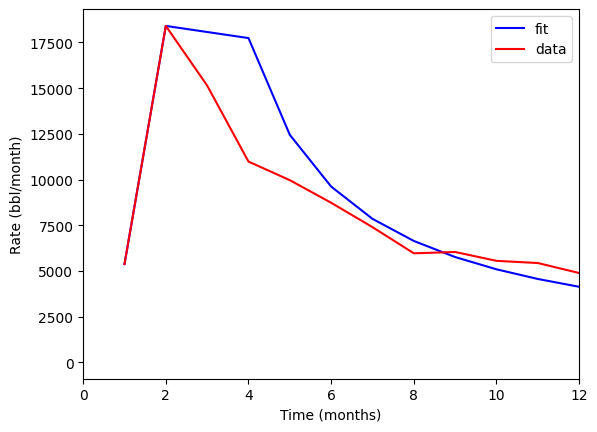

In [ ]:
plt.plot((time_), (qout), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 12)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

In [ ]:
import scipy.optimize as opt


error = error_eval(rate_,qout_f)

In [ ]:
error

113593714.518858

In [ ]:
d1 = pd.read_csv('./GCE_TC_example_bounds_qi_TCforecast.csv_')

In [ ]:
d2 = pd.read_csv('./GCE_TC_example_bounds_qi_TCsummary.csv_')

In [ ]:
d1.head()

,api,date,days_on,producing_month,oil,gas,water,well_name,operator,interval,lateral_length_ft,true_vertical_depth_ft,latitude,longitude,latitude_bh,longitude_bh,frac_proppant_lbs,frac_fluid_bbl
0,3504925089,2017-05-01,31,1,3828.0,20365.0,0,test,OVINTIV,WOODFORD,7445,12938,34.694908,-97.593008,34.717409,-97.593358,11049470.0,397945.0
1,3504925089,2017-06-01,30,2,14544.0,106303.0,0,test,OVINTIV,WOODFORD,7445,12938,34.694908,-97.593008,34.717409,-97.593358,11049470.0,397945.0
2,3504925089,2017-07-01,31,3,8852.0,89493.0,0,test,OVINTIV,WOODFORD,7445,12938,34.694908,-97.593008,34.717409,-97.593358,11049470.0,397945.0
3,3504925089,2017-08-01,31,4,7366.0,72960.0,0,test,OVINTIV,WOODFORD,7445,12938,34.694908,-97.593008,34.717409,-97.593358,11049470.0,397945.0
4,3504925089,2017-09-01,30,5,6317.0,69907.0,0,test,OVINTIV,WOODFORD,7445,12938,34.694908,-97.593008,34.717409,-97.593358,11049470.0,397945.0


In [ ]:
d3 = pd.read_csv('./Gas_Example_bounds_qi_forecast.csv')

In [ ]:
d3[d3.api==3504925089]

,api,date,index,days_on,oil_actual_daily,oil_actual_monthly,oil_pred_daily,gas_actual_daily,gas_actual_monthly,gas_pred_daily,water_actual_daily,water_actual_monthly,water_pred_daily,included_oil,included_gas,included_water,peak_index,oil_pred_monthly,gas_pred_monthly,water_pred_monthly,well_name,ngl_actual_daily,ngl_actual_monthly,ngl_actual_cumulative,ngl_pred_daily,ngl_pred_monthly,ngl_pred_cumulative,oil_actual_cumulative,oil_pred_cumulative,gas_actual_cumulative,gas_pred_cumulative,water_actual_cumulative,water_pred_cumulative,boe6_actual_daily,boe6_actual_monthly,boe6_actual_cumulative,boe6_pred_daily,boe6_pred_monthly,boe6_pred_cumulative,boe20_actual_daily,boe20_actual_monthly,boe20_actual_cumulative,boe20_pred_daily,boe20_pred_monthly,boe20_pred_cumulative,oil_combined_monthly,gas_combined_monthly,water_combined_monthly,ngl_combined_monthly,boe6_combined_monthly,boe20_combined_monthly,batch_name,unique_id,timestamp
1200,3504925089,2017-05-01,1,31,123.483871,3828.0,123.483871,656.935484,20365.0,656.935484,0.0,0.0,0,False,False,True,-23,3828.000000,20365.000000,0,TINA 2H-23X,0,0,0,0,0,0,3828.0,3828.000000,20365.0,2.036500e+04,0.0,0,232.973118,7222.166667,7222.166667,232.973118,7222.166667,7222.166667,156.330645,4846.25,4846.25,156.330645,4846.250000,4846.250000,3828.000000,20365.000000,0,0,7222.166667,4846.250000,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1201,3504925089,2017-06-01,2,30,484.800000,14544.0,429.587612,3543.433333,106303.0,3303.574813,0.0,0.0,0,True,True,False,-22,12887.628368,99107.244403,0,TINA 2H-23X,0,0,0,0,0,0,18372.0,16715.628368,126668.0,1.194722e+05,0.0,0,1075.372222,32261.166667,39483.333333,980.183415,29405.502435,36627.669102,661.971667,19859.15,24705.40,594.766353,17842.990589,22689.240589,14544.000000,106303.000000,0,0,32261.166667,19859.150000,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1202,3504925089,2017-07-01,3,31,285.548387,8852.0,322.142116,2886.870968,89493.0,2811.542715,0.0,0.0,0,True,True,False,-21,9986.405608,87157.824167,0,TINA 2H-23X,0,0,0,0,0,0,27224.0,26702.033976,216161.0,2.066301e+05,0.0,0,766.693548,23767.500000,63250.833333,790.732569,24512.709635,61140.378738,429.891935,13326.65,38032.05,462.719252,14344.296816,37033.537404,8852.000000,89493.000000,0,0,23767.500000,13326.650000,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1203,3504925089,2017-08-01,4,31,237.612903,7366.0,257.639288,2353.548387,72960.0,2474.031231,0.0,0.0,0,True,True,False,-20,7986.817941,76694.968170,0,TINA 2H-23X,0,0,0,0,0,0,34590.0,34688.851917,289121.0,2.833250e+05,0.0,0,629.870968,19526.000000,82776.833333,669.977827,20769.312636,81909.691373,355.290323,11014.00,49046.05,381.340850,11821.566349,48855.103754,7366.000000,72960.000000,0,0,19526.000000,11014.000000,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1204,3504925089,2017-09-01,5,30,210.566667,6317.0,214.601861,2330.233333,69907.0,2225.152250,0.0,0.0,0,True,True,False,-19,6438.055837,66754.567497,0,TINA 2H-23X,0,0,0,0,0,0,40907.0,41126.907753,359028.0,3.500796e+05,0.0,0,598.938889,17968.166667,100745.000000,585.460570,17563.817086,99473.508459,327.078333,9812.35,58858.40,325.859474,9775.784212,58630.887965,6317.000000,69907.000000,0,0,17968.166667,9812.350000,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,3504925089,2066-12-01,596,31,NaN,NaN,0.552543,NaN,NaN,19.748000,NaN,NaN,0,NaN,NaN,NaN,572,17.128840,612.187990,0,TINA 2H-23X,0,0,0,0,0,0,NaN,201087.236423,NaN,4.317385e+06,NaN,0,NaN,NaN,NaN,3.843877,119.160172,920651.337478,NaN,NaN,NaN,1.539943,47.738240,416956.466739,17.128840,612.187990,0,0,119.160172,47.738240,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1796,3504925089,2067-01-01,5

In [ ]:
d4 = pd.read_csv('./Gas_Example_bounds_qi_summary.csv')

In [ ]:
d4.head()

,segment,segment_final,single_segment_flag,forecast_override,forecast_type,gor_override,wor_override,t_start,t_start_date,t_seg_months,t_end,t_end_date,primary_phase,peak_month_oil,peak_month_gas,peak_month_water,oil_pre_forecast,gas_pre_forecast,water_pre_forecast,ngl_pre_forecast,qi_oil,b_oil,di_nom_oil,di_sec_oil,di_tan_oil,dlim_nom_oil,dlim_sec_oil,dlim_tan_oil,qi_gas,b_gas,di_nom_gas,di_sec_gas,di_tan_gas,dlim_nom_gas,dlim_sec_gas,dlim_tan_gas,qi_water,b_water,di_nom_water,di_sec_water,di_tan_water,dlim_nom_water,dlim_sec_water,dlim_tan_water,volatility_score,volatility_flag,convergence_oil,iterations_oil,error_oil,error_perc_oil,error_abs_oil,error_abs_perc_oil,convergence_gas,iterations_gas,error_gas,error_perc_gas,error_abs_gas,error_abs_perc_gas,convergence_water,iterations_water,error_water,error_perc_water,error_abs_water,error_abs_perc_water,api,well_name,operator,interval,latitude,longitude,latitude_bh,longitude_bh,lateral_length_ft,true_vertical_depth_ft,frac_proppant_lbs,frac_fluid_bbl,net_revenue_interest,working_interest,ip_year,q_lim_oil,q_lim_gas,q_lim_water,q_final_oil,q_final_gas,q_final_water,q_lim_ngl,q_final_ngl,oil_actual_cumulative,oil_eur,oil_remaining,gas_actual_cumulative,gas_eur,gas_remaining,water_actual_cumulative,water_eur,water_remaining,ngl_actual_cumulative,ngl_eur,ngl_remaining,boe6_actual_cumulative,boe6_eur,boe6_remaining,boe20_actual_cumulative,boe20_eur,boe20_remaining,error_flag,batch_name,unique_id,timestamp
0,single_segment_1,True,True,False,Single Well,False,False,1,2018-02-01,59,60,2023-01-01,GAS,2018-04-01,2018-04-01,2018-02-01,11182,13751,0,0,456.260000,0.957801,6.946948,0.880551,0.999038,0.072571,0.067755,0.07,2018.370000,1.484515,0.653007,0.366523,0.479522,0.072571,0.066600,0.07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.354839,True,NON-CONVERGENCE,66,-557.174781,-0.006901,8836.612917,0.109451,CONVERGED,33,182906.308014,0.093176,499208.567125,0.254306,NON-CONVERGENCE,NaN,0,0,0,0,3504925141,N HAYS 2H-5X,OVINTIV,WOODFORD,34.680180,-97.540276,34.653276,-97.542468,9504,12277,14052555.0,339660.0,NaN,NaN,2018,3.898504,459.474373,NaN,0.295328,22.543077,0,NaN,NaN,91918,132276.920204,40358.920204,1976775,4.839698e+06,2.862923e+06,0,0,0,0,0,0,421380.500000,9.388933e+05,517512.816254,190756.75,374261.839019,183505.089019,False,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
1,single_segment_1,True,True,False,Single Well,False,False,1,2018-02-01,59,60,2023-01-01,GAS,2018-04-01,2018-05-01,2018-02-01,11540,77579,0,0,768.494996,0.868874,8.776126,0.916247,0.999846,0.072571,0.067955,0.07,2513.501766,1.488256,0.541610,0.327805,0.418189,0.072571,0.066592,0.07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129032,False,NON-CONVERGENCE,53,-456.475285,-0.004453,15681.433367,0.152969,NON-CONVERGENCE,57,80886.835963,0.033262,485160.751963,0.199504,NON-CONVERGENCE,NaN,0,0,0,0,3504925143,N HAYS 4H-5X,OVINTIV,WOODFORD,34.680180,-97.540146,34.652275,-97.538160,9989,12100,14978399.0,373888.0,NaN,NaN,2018,3.081861,651.233307,NaN,0.260154,31.607571,0,NaN,NaN,114054,150908.113767,36854.113767,2509412,6.521060e+06,4.011648e+06,0,0,0,0,0,0,532289.333333,1.237751e+06,705462.102975,239524.60,476961.110529,237436.510529,False,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
2,single_segment_1,True,True,False,Single Well,False,False,1,2017-05-01,68,69,2023-01-01,GAS,2017-06-01,2017-06-01,2017-05-01,3828,20365,0,0,509.040000,0.985596,4.689276,0.826551,0.990807,0.072571,0.067693,0.07,3632.029007,1.600000,2.557913,0.638457,0.922534,0.072571,0.066354,0.07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027778,False,CONVERGED,25,-1137.010329,-0.009721,11686.144367,0.099916,CONVERGED,14,109803.703965,0.056707,391008.455855,0.201932,NON-CONVERGENCE,NaN,0,0,0,0,3504925089,TINA 2H-23X,OVINTIV,WOODFORD,34.694908,-97.593008,34.717409,-97.593358,7445,12938,11049470.0,397945.0,NaN,NaN,2017,7.412264,391.919188,NaN,0.539337,19.276023,0,NaN,NaN,122117,189668.590913,67551.590913,1978757,4.286726e+06,2.307969e+06,0,0,0,0,0,0,451909.8

In [ ]:
forcast2 = pd.read_csv('./GCE_TC_example_bounds_qi_TCforecast2.csv_')

In [ ]:
forcast2.head()

,date,index,days_on,oil_actual_daily,oil_actual_monthly,oil_pred_daily,gas_actual_daily,gas_actual_monthly,gas_pred_daily,water_actual_daily,water_actual_monthly,water_pred_daily,included_oil,included_gas,included_water,peak_index,oil_pred_monthly,gas_pred_monthly,water_pred_monthly,api,well_name,ngl_actual_daily,ngl_actual_monthly,ngl_actual_cumulative,ngl_pred_daily,ngl_pred_monthly,ngl_pred_cumulative,oil_actual_cumulative,oil_pred_cumulative,gas_actual_cumulative,gas_pred_cumulative,water_actual_cumulative,water_pred_cumulative,boe6_actual_daily,boe6_actual_monthly,boe6_actual_cumulative,boe6_pred_daily,boe6_pred_monthly,boe6_pred_cumulative,boe20_actual_daily,boe20_actual_monthly,boe20_actual_cumulative,boe20_pred_daily,boe20_pred_monthly,boe20_pred_cumulative,oil_combined_monthly,gas_combined_monthly,water_combined_monthly,ngl_combined_monthly,boe6_combined_monthly,boe20_combined_monthly,batch_name,unique_id,timestamp
0,2017-06-01,1,30.4375,250.421706,7622.210679,250.421706,994.646620,30274.556501,994.646620,0,0,0,False,False,False,-4,7622.210679,30274.556501,0,3504925089 | 3504925090 | 3504925091 | 3504925...,test,0,0,0,0,0,0,7622.210679,7622.210679,30274.556501,30274.556501,0,0,416.196143,12667.970096,12667.970096,416.196143,12667.970096,12667.970096,300.154037,9135.938504,9135.938504,300.154037,9135.938504,9135.938504,7622.210679,30274.556501,0,0,12667.970096,9135.938504,SMART TC,SMART_TC__2023-11-28-T092409UTC,2023-11-28 09:24:09
1,2017-07-01,2,30.4375,820.659304,24978.817576,820.659304,3958.374342,120483.019026,3958.374342,0,0,0,False,False,False,-3,24978.817576,120483.019026,0,3504925089 | 3504925090 | 3504925091 | 3504925...,test,0,0,0,0,0,0,32601.028256,32601.028256,150757.575527,150757.575527,0,0,1480.388361,45059.320748,57727.290843,1480.388361,45059.320748,57727.290843,1018.578021,31002.968528,40138.907032,1018.578021,31002.968528,40138.907032,24978.817576,120483.019026,0,0,45059.320748,31002.968528,SMART TC,SMART_TC__2023-11-28-T092409UTC,2023-11-28 09:24:09
2,2017-08-01,3,30.4375,639.481554,19464.219811,612.117292,3707.517292,112847.557565,3730.073769,0,0,0,False,False,False,-2,18631.320089,113534.120333,0,3504925089 | 3504925090 | 3504925091 | 3504925...,test,0,0,0,0,0,0,52065.248066,51232.348345,263605.133092,264291.695860,0,0,1257.401103,38272.146072,95999.436915,1233.796254,37553.673478,95280.964322,824.857419,25106.597689,65245.504721,798.620981,24308.026106,64446.933138,19464.219811,112847.557565,0,0,38272.146072,25106.597689,SMART TC,SMART_TC__2023-11-28-T092409UTC,2023-11-28 09:24:09
3,2017-09-01,4,30.4375,465.457587,14167.365303,456.568978,3266.559031,99425.890501,3514.940508,0,0,0,True,False,False,-1,13896.818262,106986.001712,0,3504925089 | 3504925090 | 3504925091 | 3504925...,test,0,0,0,0,0,0,66232.613370,65129.166607,363031.023592,371277.697573,0,0,1009.884092,30738.347054,126737.783969,1042.392396,31727.818548,127008.782870,628.785539,19138.659828,84384.164550,632.316003,19246.118348,83693.051486,14167.365303,99425.890501,0,0,30738.347054,19138.659828,SMART TC,SMART_TC__2023-11-28-T092409UTC,2023-11-28 09:24:09
4,2017-10-01,5,30.4375,429.947649,13086.531572,401.429281,3222.594065,98087.706857,3312.215131,0,0,0,True,False,False,0,12218.503731,100815.548038,0,3504925089 | 3504925090 | 3504925091 | 3504925...,test,0,0,0,0,0,0,79319.144942,77347.670338,461118.730450,472093.245611,0,0,967.046660,29434.482715,156172.266684,953.465136,29021.095071,156029.877940,591.077352,17990.916915,102375.081465,567.040037,17259.281133,100952.332619,13086.531572,98087.706857,0,0,29434.482715,17990.916915,SMART TC,SMART_TC__2023-11-28-T092409UTC,2023-11-28 09:24:09
